In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def data_augmentation(rot=25, crop=True, hflip=True, vflip=True):
    transform_list = []
    # if rot:
    #     transform_list.append(transforms.RandomRotation(rot))
    # if hflip:
    #     transform_list.append(transforms.RandomHorizontalFlip())
    # if vflip:
    #     transform_list.append(transforms.RandomVerticalFlip())

    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))

    return transforms.Compose(transform_list)

In [7]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = csv_file.values
        self.labels = data[:, 0]
        self.images = data[:, 1:].reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        image = Image.fromarray(image)  # Convert numpy to PIL

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data from csv
from torch.utils.data import random_split


train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")
train_set = FashionMNISTDataset(train_csv, transform = data_augmentation())
test_set = FashionMNISTDataset(test_csv, transform =  data_augmentation())
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 32, shuffle=True)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

Train set size: 48000
Validation set size: 12000
Test set size: 10000


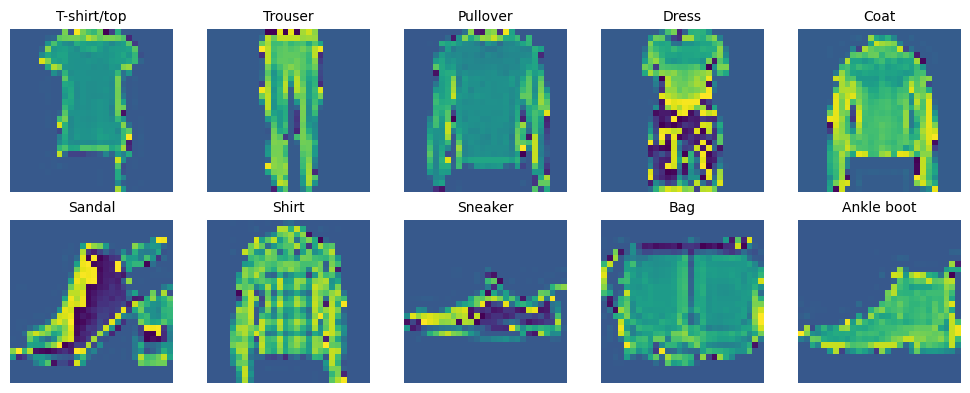

In [8]:
#class mapping
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def show_one_per_class(dataset, class_names=None, num_classes=None, rows=2, cols=5):

    seen = {}
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        _, label = dataset[idx]
        label = int(label)
        if label not in seen:
            seen[label] = idx
        if num_classes and len(seen) >= num_classes:
            break

    # Sort the labels for consistent display
    sorted_items = sorted(seen.items(), key=lambda x: x[0])
    total = len(sorted_items)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, (label, idx) in enumerate(sorted_items):
        image, _ = dataset[idx]

        if isinstance(image, torch.Tensor):
            image = image.clone()
            image = image * 0.5 + 0.5  # unnormalize if needed
            image = to_pil_image(image)

        axes[i].imshow(image)
        axes[i].set_title(class_names[label] if class_names else f"Class {label}", fontsize=10)
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

show_one_per_class(train_set, list(class_names.values()))

# Model Summary
* Architecture includes a CNN + Residual Network + Transformer, mimicking a hybrid ViT
* 1 convolutional layer + 1 residual block (from chatgpt, need help confirming)
* Ending with 32 feature maps and 14x14 spatial size (from chatgpt, need help confirming)
* 2 fully connected blocks of size 12544 (from chatgpt, need helpp confirming)
* Final output layer to 10 classes (from chatgpt, need helpp confirming)

In [9]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, heads=4, ff_dim=128, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        # Feedforward
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [11]:
class DNNv3(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # CNN block
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # Fashion MNIST has 1 channel
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Residual block
        self.resblock = ResidualBlock(32)

        # Flatten/Patchify
        self.flatten_dim = 32 * 14 * 14  # After conv+pooling
        self.patch_dim = 196  # 14x14 = 196 tokens
        self.embedding_dim = 64
        self.linear_proj = nn.Linear(32, self.embedding_dim)

        # Transformer encoder
        self.transformer = TransformerEncoder(dim=self.embedding_dim)

        # Final classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.patch_dim * self.embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.resblock(x)

        # Prepare for transformer: reshape to (batch, tokens, features)
        B, C, H, W = x.shape  # Expecting (B, 32, 14, 14)
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)  # (B, 196, 32)
        x = self.linear_proj(x)  # (B, 196, embedding_dim)

        x = self.transformer(x)

        out = self.classifier(x)
        return out

In [12]:
# Training setup
model = DNNv3().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Evaluate model

In [13]:
def evaluate(model, dataloader, device, set_name="Test"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{set_name} Accuracy: {accuracy:.2f}%")
    model.train()  # set back to training mode after evaluation

# Train model

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=15):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        avg_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            avg_loss += loss.item() / len(train_loader)

        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss:.4f}, Average Loss: {avg_loss:.4f}")

        # Evaluate on validation set
        evaluate(model, val_loader, device, set_name="Validation")

# Run model

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(model, train_loader, val_loader, criterion, optimizer, device, epochs=15)
evaluate(model, test_loader, device, set_name="Test")

Epoch 1/15, Total Loss: 668.2250, Average Loss: 0.4455
Validation Accuracy: 88.10%
Epoch 2/15, Total Loss: 446.9315, Average Loss: 0.2980
Validation Accuracy: 90.91%
Epoch 3/15, Total Loss: 377.0617, Average Loss: 0.2514
Validation Accuracy: 91.16%
Epoch 4/15, Total Loss: 329.5346, Average Loss: 0.2197
Validation Accuracy: 91.41%
Epoch 5/15, Total Loss: 293.0516, Average Loss: 0.1954
Validation Accuracy: 90.17%
Epoch 6/15, Total Loss: 257.7424, Average Loss: 0.1718
Validation Accuracy: 91.64%
Epoch 7/15, Total Loss: 230.8278, Average Loss: 0.1539
Validation Accuracy: 91.16%
Epoch 8/15, Total Loss: 200.4464, Average Loss: 0.1336
Validation Accuracy: 91.27%
Epoch 9/15, Total Loss: 182.5972, Average Loss: 0.1217
Validation Accuracy: 92.26%
Epoch 10/15, Total Loss: 161.0676, Average Loss: 0.1074
Validation Accuracy: 92.58%
Epoch 11/15, Total Loss: 147.6777, Average Loss: 0.0985
Validation Accuracy: 92.32%
Epoch 12/15, Total Loss: 134.5037, Average Loss: 0.0897
Validation Accuracy: 92.04%
E

# Test model & Double confirm test accuracy

In [16]:
model.eval()
correct = total = 0

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Test Accuracy: 92.86%


# Evaluation metrics

In [17]:
all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(data)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Confusion matrix

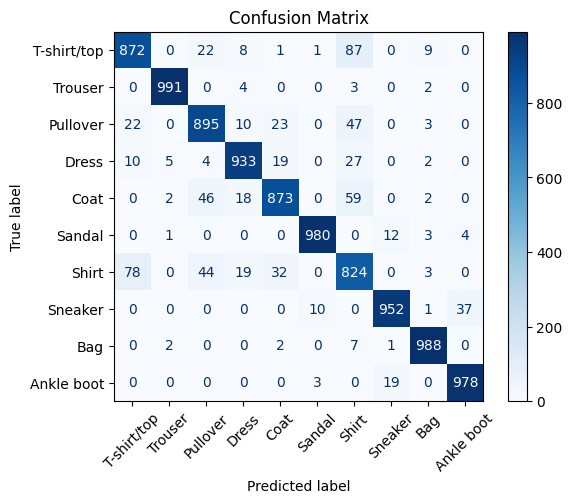

In [23]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1 Score

In [25]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(class_names.values())))

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.87      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.90      0.89      1000
       Dress       0.94      0.93      0.94      1000
        Coat       0.92      0.87      0.90      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.78      0.82      0.80      1000
     Sneaker       0.97      0.95      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# Top k accuracy, k = 3

In [26]:
topk = 3
topk_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(data)
        _, topk_preds = outputs.topk(topk, dim=1)  # [batch, topk]
        match = topk_preds.eq(labels.view(-1, 1))  # [batch, topk]

        topk_correct += match.any(dim=1).sum().item()
        total += labels.size(0)

topk_acc = topk_correct / total * 100
print(f"Top-{topk} Accuracy: {topk_acc:.2f}%")

Top-3 Accuracy: 99.45%


# ROC-AUC / PR - AUC

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# One-hot encode labels
y_true_bin = label_binarize(all_labels, classes=list(range(10)))
roc_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
print(f"Multiclass ROC-AUC (macro avg): {roc_auc:.4f}")

Multiclass ROC-AUC (macro avg): 0.9957
